In [175]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

In [94]:
import warnings

warnings.filterwarnings('ignore')

### 2. Необходимо самостоятельно собрать данные для выбранного товара. Данные должны представлять собой перекрестную (пространственную) выборку. Описать источник данных, переменные для анализа (как рассчитываются и в чем измеряются). Провести анализ описательных статистик и графический анализ переменных.

In [72]:
df = pd.read_csv('df_new_factors.csv')
df.head()

,Размер,Категория,Бренд,Материал сумок,Цвет,Длина ручки,Наличие пыльника,Состояние товара,Модель,Винтаж,Наличие коробки,Наличие сертификата,Ценовая категория,Метод производства,Легенда,Цена
0,INT L,Сумки с короткими ручками,MARC JACOBS,Экзотическая кожа,Серебряный,Средние ручки,1,Отличное состояние,Ordinary,0,0,0,Дорогие,Произведенные на фабрике,0,52000
1,INT S,Клатчи и вечерние сумки,VERSACE,Кожа,Черный,Короткие ручки,0,Отличное состояние,Ordinary,0,0,0,Дорогие,Произведенные на фабрике,0,38000
2,INT M,Сумки через плечо,BALENCIAGA,Кожа,Желтый,Длинный ремень,0,Новое с биркой,Crush,0,0,0,Люксовые,Произведенные на фабрике,1,345000
3,INT U,Сумки с короткими ручками,BURBERRY,Кожа,Коричневый,Средние ручки,0,Отличное состояние,Ordinary,1,0,0,Люксовые,Произведенные на фабрике,0,27000
4,INT M,Сумки с короткими ручками,KARL LAGERFELD,Искусственная кожа,Мульти,Средние ручки,0,Новое с биркой,Ordinary,0,0,0,Доступные,Произведенные на фабрике,0,17950


In [7]:
df.shape

(1051, 16)

Размер выборки - 1051 наблюдение/моделей сумок. Всего 15 рассматриваемых характеристик.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Размер               1051 non-null   object
 1   Категория            1051 non-null   object
 2   Бренд                1051 non-null   object
 3   Материал сумок       1051 non-null   object
 4   Цвет                 1051 non-null   object
 5   Длина ручки          1051 non-null   object
 6   Наличие пыльника     1051 non-null   int64 
 7   Состояние товара     1051 non-null   object
 8   Модель               1051 non-null   object
 9   Винтаж               1051 non-null   int64 
 10  Наличие коробки      1051 non-null   int64 
 11  Наличие сертификата  1051 non-null   int64 
 12  Ценовая категория    1051 non-null   object
 13  Метод производства   1051 non-null   object
 14  Легенда              1051 non-null   int64 
 15  Цена                 1051 non-null   int64 
dtypes: int

Параметры в нашей выборке имеют категориальный и бинарный тип данных.

In [73]:
# отдельно выделим категориальные и дамми переменные
cat_feats = df.select_dtypes(include='object').columns.to_list()

bin_feats = df.select_dtypes(include='number').columns.to_list()
bin_feats.remove('Цена')

# зависимая переменная - количественная
quant_feats = ['Цена']

Начнем анализ данных с целевой переменной.

---

#### 2.1 Анализ целевой переменной

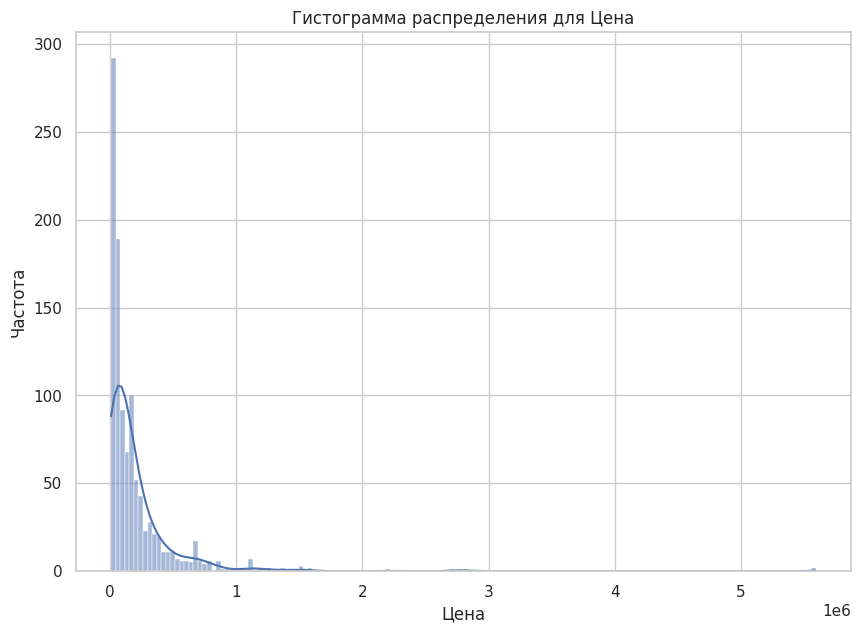

Скошенность: 8.049594378924823
Островершинность: 99.60939372241275
--------------------------------------------------------------------------------


In [74]:
from scipy.stats import skew, kurtosis

def skew_kurt_feat(feat):
    plt.figure(figsize=(10, 7))

    sns.histplot(df[feat], kde=True)
    plt.title(f'Гистограмма распределения для {feat}')
    plt.xlabel(feat)
    plt.ylabel('Частота')

    plt.show()

    display(HTML(f'Показатели для <b>{feat}</b>'))
    print(f'Скошенность: {skew(df[feat])}')
    print(f'Островершинность: {kurtosis(df[feat])}')
    print('--------------------------------------------------------------------------------')

skew_kurt_feat(quant_feats[0])

По построенному графику видно, что цены сумок распределены с очень длинным правым хвостом и тяжёлым левым хвостом. Показатель скошенности равный примерно 8 (при значении 0 для нормального распределения) говорит о сильной асимметрии: большинство товаров сконцентрировано внизу ценовой шкалы, но небольшое число лотов стоит в разы дороже и тянет распределение вправо. Островершинность около 100 (при показателе 3 у нормального распределения) означает, что вероятность появления экстремально высоких и низких цен намного выше, чем при нормальном распределении, то есть для выборки присуща высокая частота выбросов. Вероятно распределение прологарифмированной цены будет выглядеть сильно лучше. Взглянем на него.

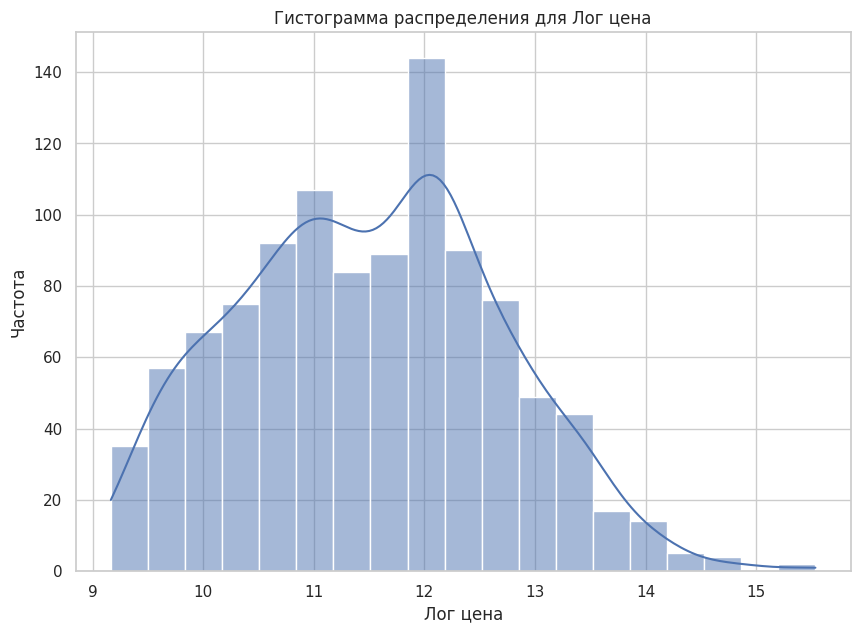

Скошенность: 0.15836535158553108
Островершинность: -0.4665477186972127
--------------------------------------------------------------------------------


In [75]:
# добавляем признак в виде логарифмированной цены
df['Лог цена'] = np.log(df['Цена'])
skew_kurt_feat('Лог цена')

Видим, что в данном случае все сильно лучше. Показатель скошенности близкий к 0 говорит о почти симметричном распределении. Показатель -0.47 островершинности указывает на плоское распределение с менее выраженными пиками и более тонкими хвостами по сравнению с нормальным распределением. По данным показателям можно сказать, что распределение близко к нормальному.

И на графике распределения обычных цен, и на графике распределения логарифмированных цен в правом хвосте имеются ненулевые столбцы, растягивающие его. Посмотрим на ящики с усами для разных форм цен и проверим наличие выбросов, которые вполне могут лежать в ранее упомянутых столбцах, то есть их учитывание также может позволить нам приблизить распределение цен к нормальному.

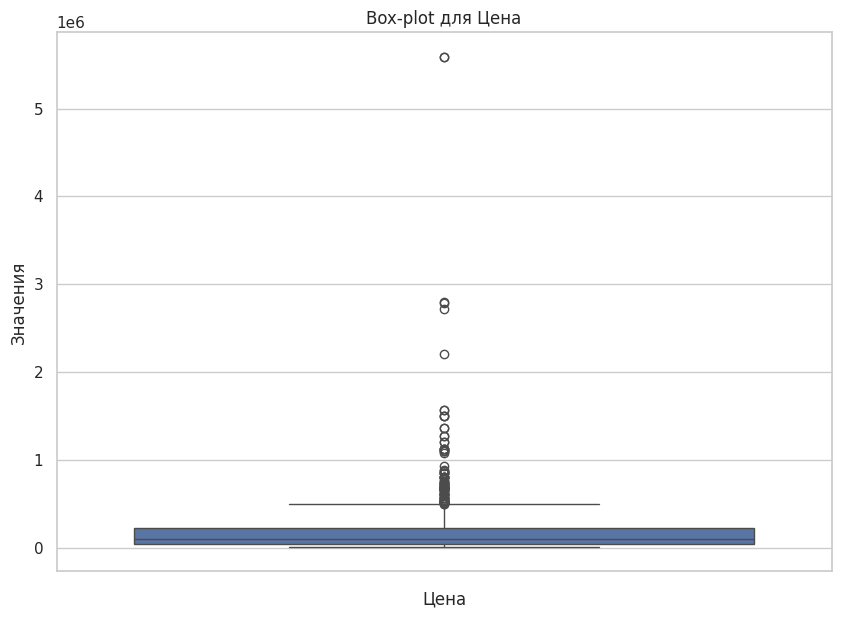

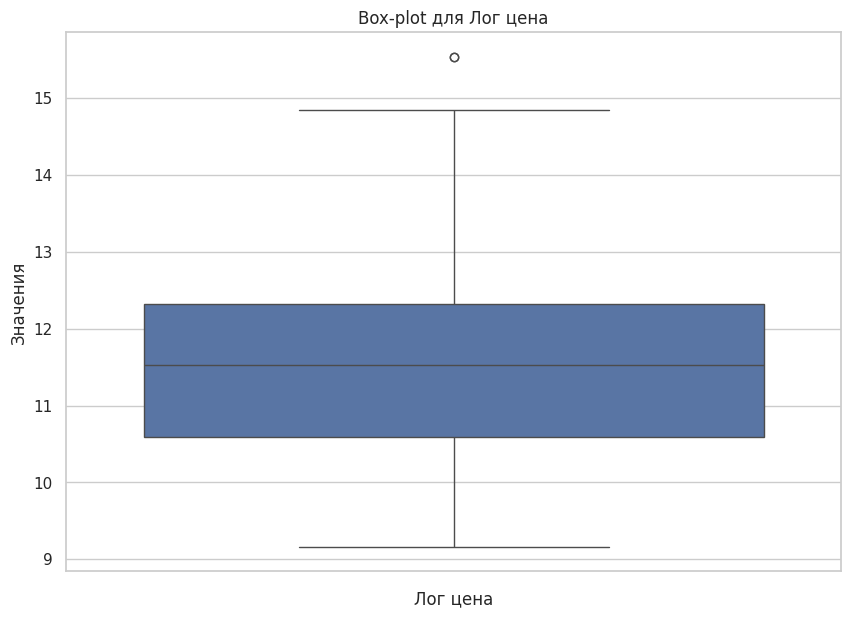

In [ ]:
for feat in ['Цена', 'Лог цена']:
    plt.figure(figsize=(10, 7))

    sns.boxplot(df[feat])
    plt.title(f'Box-plot для {feat}')
    plt.xlabel(f'{feat}')
    plt.ylabel('Значения')
    plt.show()

Судя по ящику с усами для обычной цены, в выборке присутствует довольно большое количество выбросов. Для более строгого учета экстремальных значений стоимости (так как может оказаться, что при полном избавлении от выбросов выборка потеряет часть важной информации, при использовании которой созданные нами модели могут работать лучше чем без неё) на данном этапе избавимся от объектов, чья цена располагается сильно дальше от основного скопления точек, а точнее больше 2 млн. рублей.

In [76]:
# избавляемся от очевидных выбросов
df = df[df['Цена'] <= 2000000]

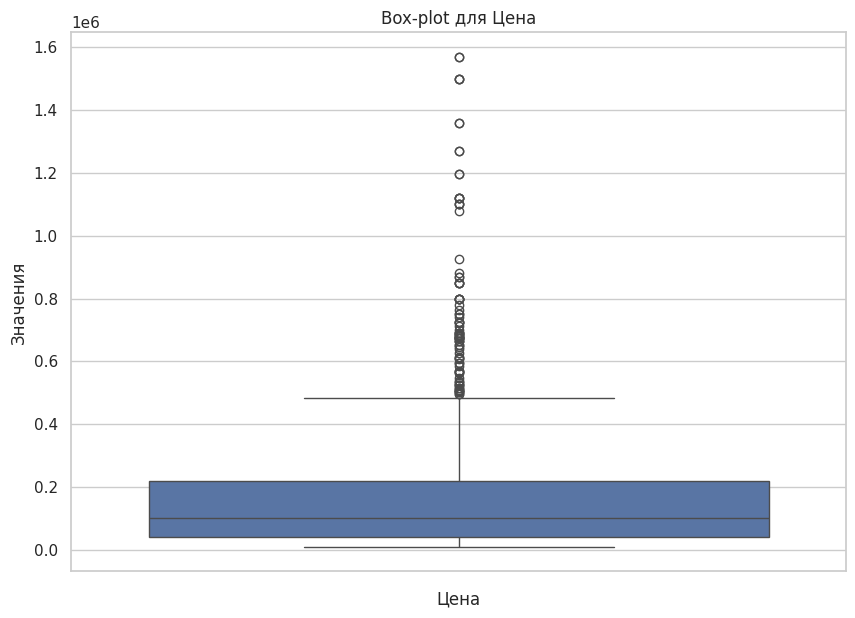

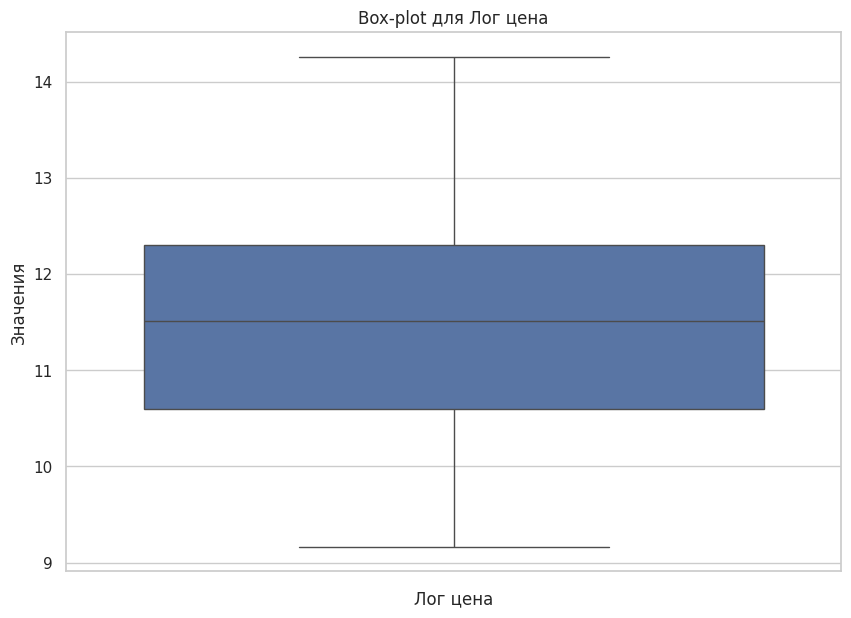

In [67]:
for feat in ['Цена', 'Лог цена']:
    plt.figure(figsize=(10, 7))

    sns.boxplot(df[feat])
    plt.title(f'Box-plot для {feat}')
    plt.xlabel(f'{feat}')
    plt.ylabel('Значения')
    plt.show()

Теперь на графике логарифмированных цен и вовсе нет выбросов. Дальнейшую работу с экстремальными значениями продолжим при построении моделей.

Следующими подробнее рассмотрим дамми переменные.

---

#### 2.2 Анализ дамми переменных

Посмотрим на основные описательные статистики дамми переменных.

In [ ]:
def descriptive_statistics(data, feats_not_to_count):
    feats = sorted(set(data.columns) - set(feats_not_to_count))
    
    metrics = [
        'Минимум',
        'Максимум',
        'Среднее',
        'Стд. отклонение',
        'Размах'
    ]
    
    stats = {
        feat: [
            data[feat].min(),
            data[feat].max(),
            data[feat].mean(),
            data[feat].std(ddof=1),
            data[feat].max() - data[feat].min()
        ]
        for feat in feats
    }
    
    stats_df = pd.DataFrame(stats, index=metrics)
    return stats_df


descriptive_statistics(df, cat_feats)

,Винтаж,Легенда,Лог цена,Наличие коробки,Наличие пыльника,Наличие сертификата,Цена
Минимум,0.000000,0.000000,9.164087,0.000000,0.000000,0.000000,9.548000e+03
Максимум,1.000000,1.000000,14.266586,1.000000,1.000000,1.000000,1.570000e+06
Среднее,0.067943,0.108134,11.486185,0.088995,0.292823,0.084211,1.829012e+05
Стд. отклонение,0.251768,0.310698,1.151937,0.284873,0.455276,0.277836,2.316213e+05
Размах,1.000000,1.000000,5.102499,1.000000,1.000000,1.000000,1.560452e+06


Выводы:

- лишь у 8% сумок из выборки имеется сертификат
- пыльник присутствует примерно у 30% рассматриваемых моделей
- только 9% из всех сумок в выборке поставляются в коробках
- винтажных сумок всего 6% от всей выборки
- средняя стоимость рассматриваемых моделей составила 202.5 тыс. рублей
- стандартное отклонение стоимости довольно велико и составляет примерно 363 тыс. рублей
- размах цен сумок довольно большой - от 9 тыс. до 5.6 млн. рублей

Общий разброс стоимостей сумок, с учетом показателя стандартного отклонения, немал, из-за чего распределение цен может выглядеть довольно растянутым - взглянем на него повнимательнее.

Теперь посмотрим на корреляционную матрицу численных характеристик.

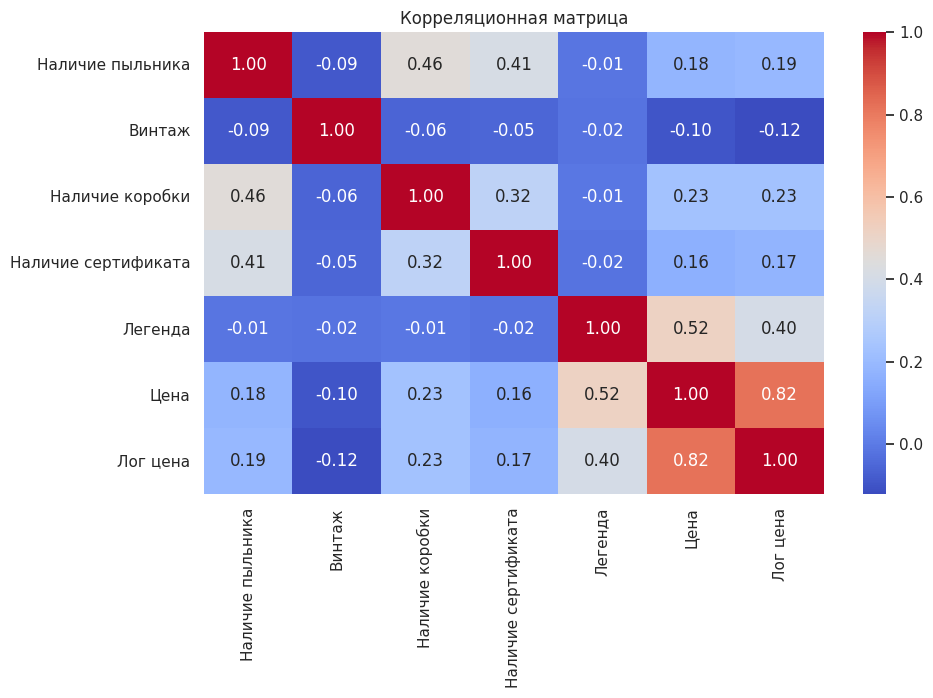

In [83]:
corr_matrix = df.drop(columns=cat_feats).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')

plt.show()

Довольно удивительно и не совсем интуитивно оказалось, что из численных переменных лучше всего с ценой коррелирует наличие легенды. Другие параметры коррелируют со стоимостью довольно слабо.

Перейдем к рассмотрению категориальных переменных.

----

#### 2.3 Анализ категориальных переменных

Посмотрим на распределения категориальных переменных.

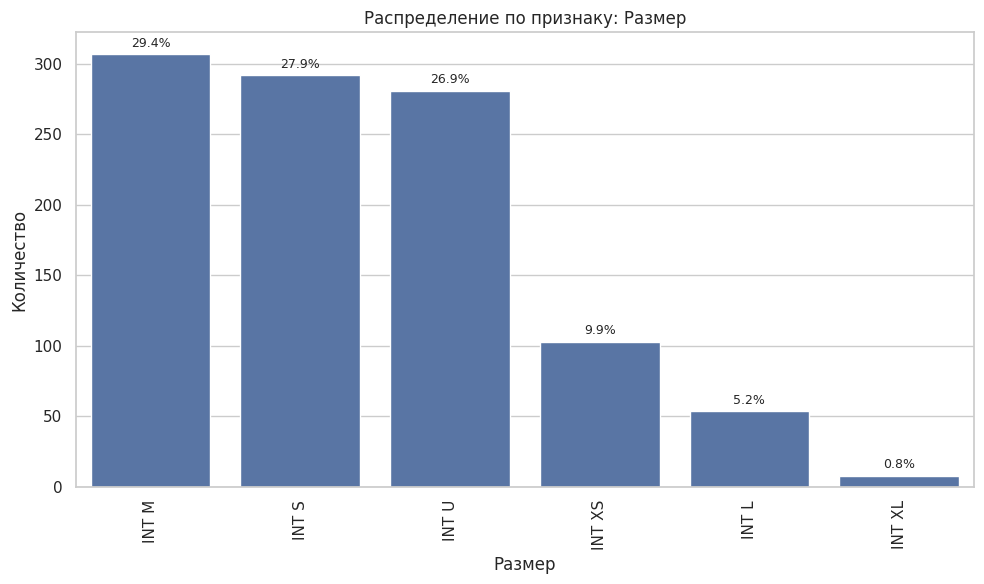

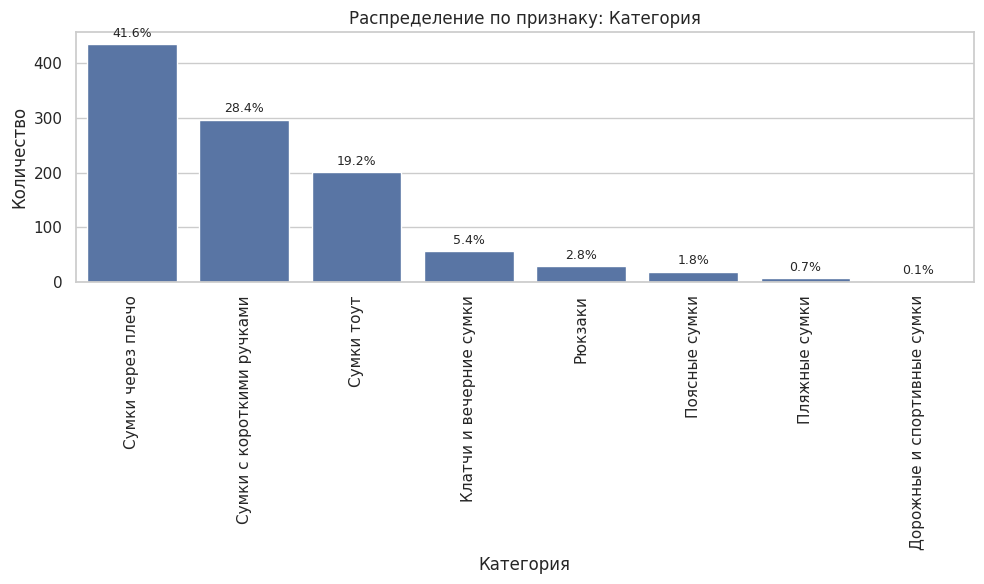

/tmp/ipykernel_209359/3948675432.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.lower() for label in labels])


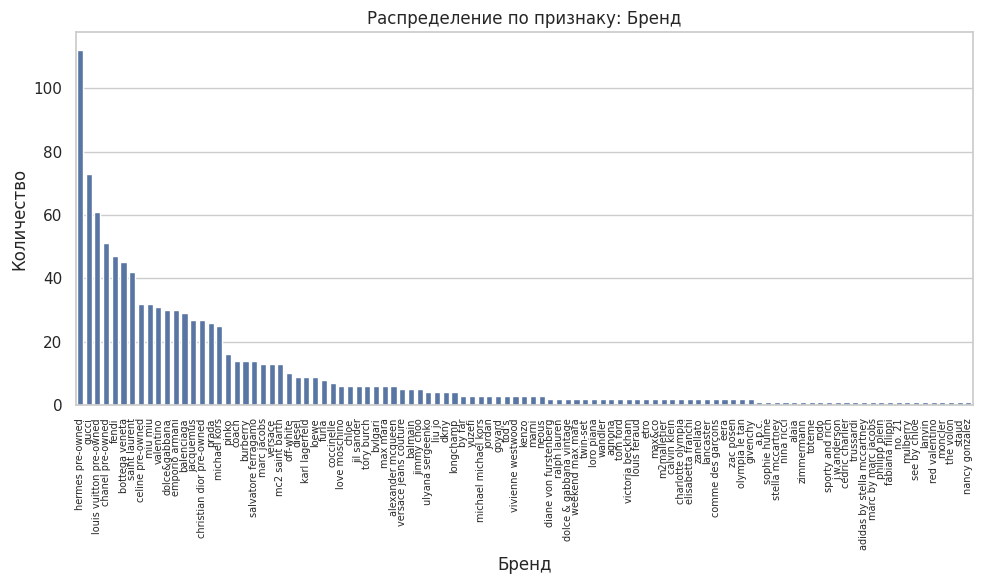

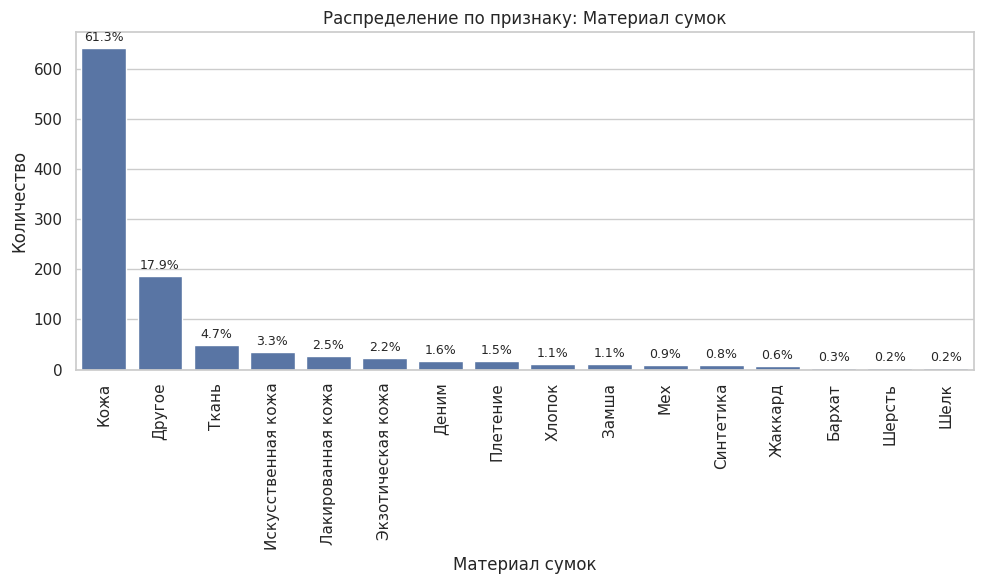

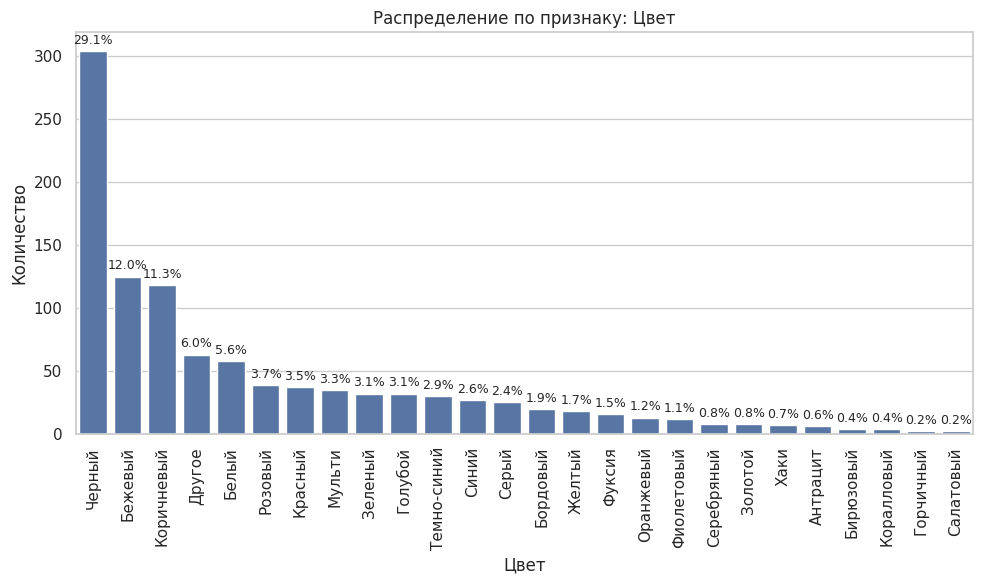

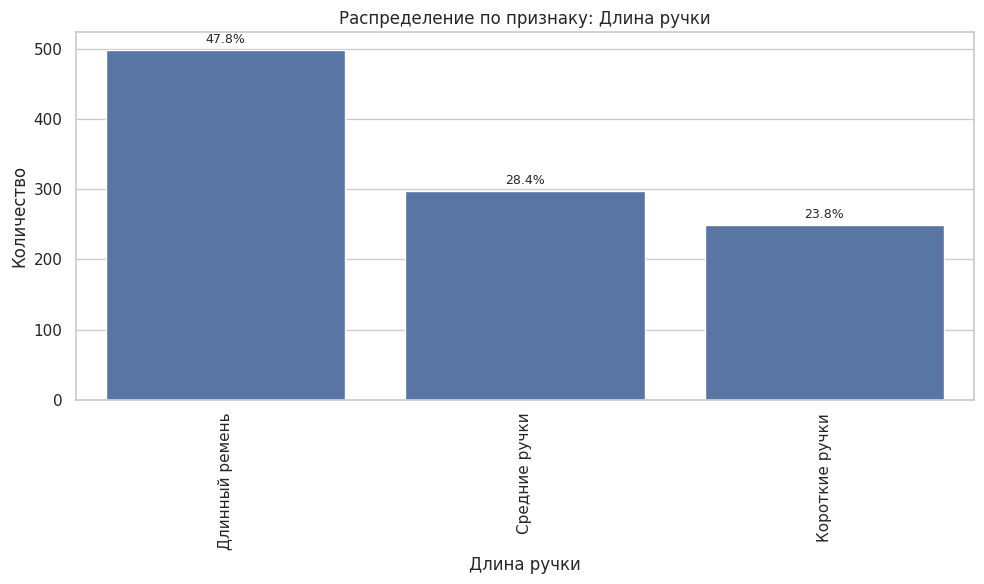

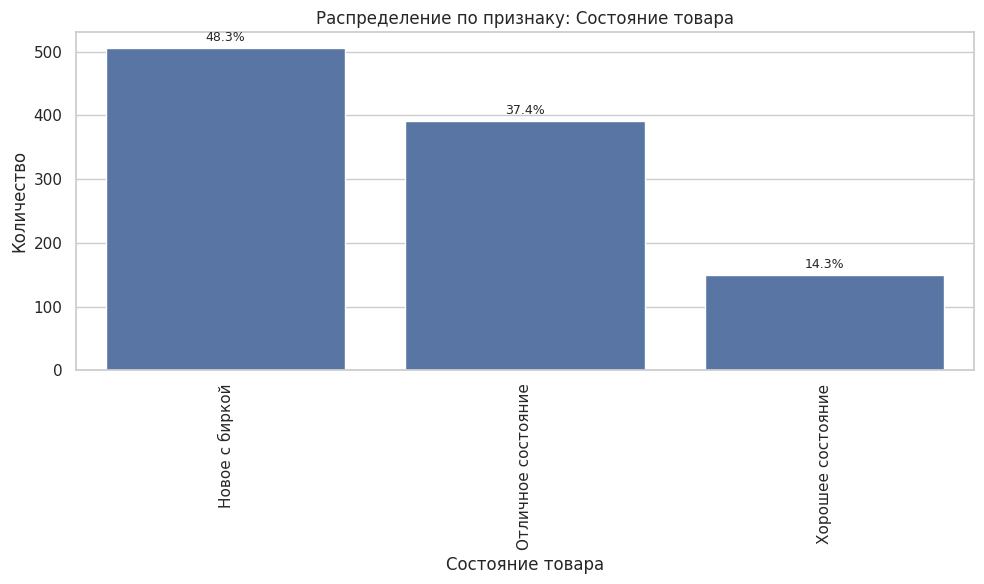

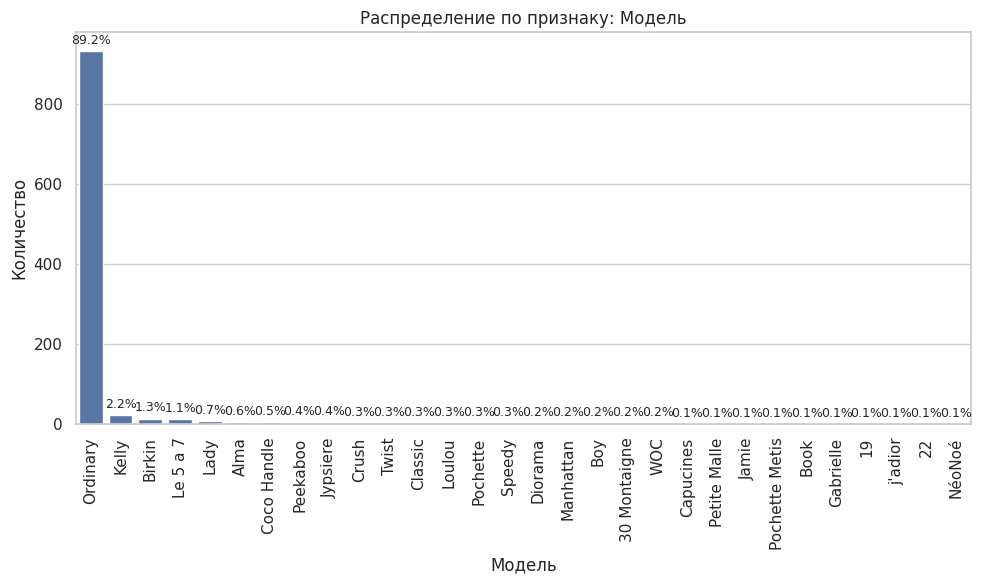

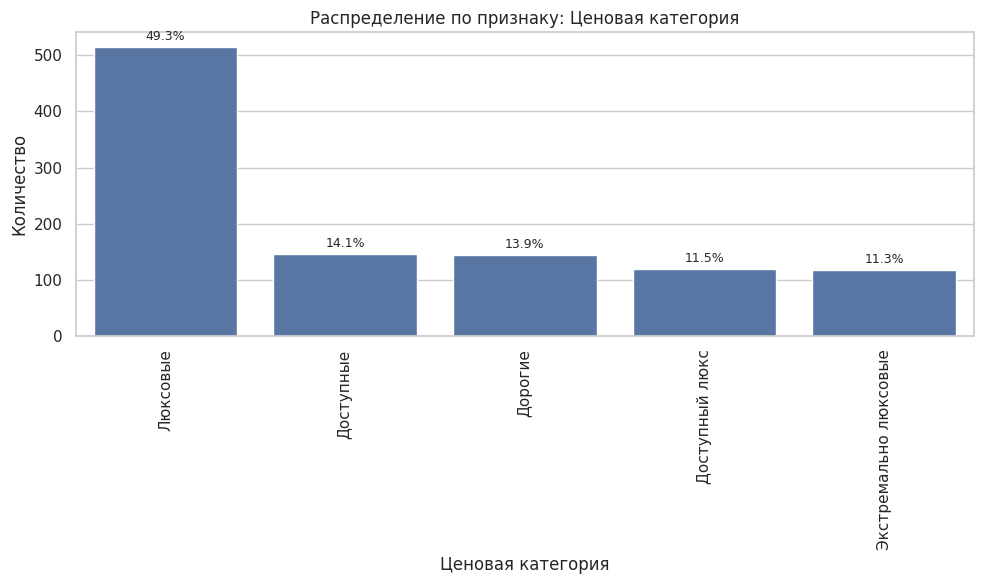

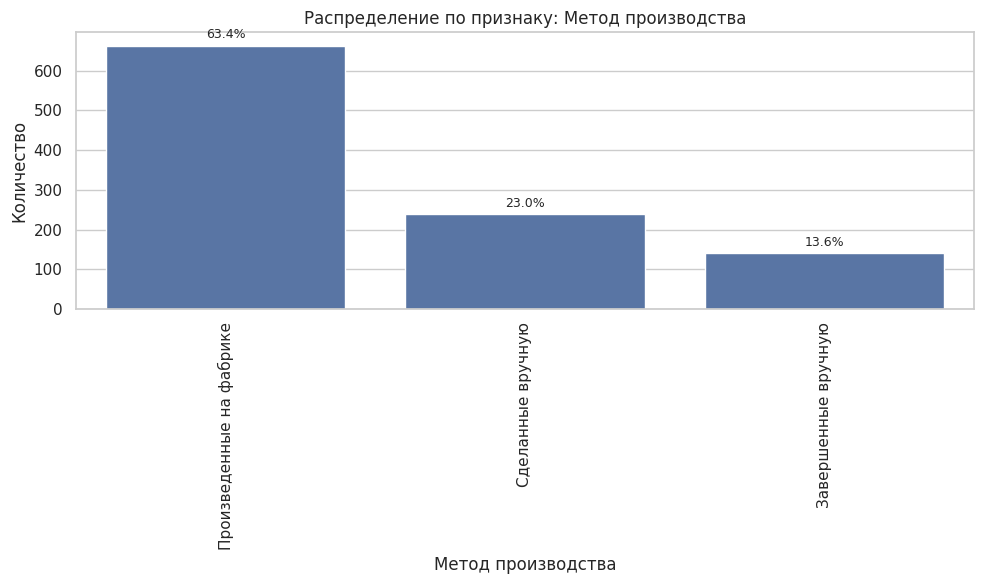

In [ ]:
sns.set(style="whitegrid")

total = len(df)

for col in cat_feats:
    plt.figure(figsize=(10, 6))

    if col == 'Бренд':
        ax = sns.countplot(data=df, x='Бренд', order=df['Бренд'].value_counts().index, width=0.7)
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels([label.lower() for label in labels])
        ax.tick_params(axis='x', labelsize=7)
        
    else:
        ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index)

        for p in ax.patches:
            count = p.get_height()
            pct = count / total * 100
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(f'{pct:.1f}%', (x, y), ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points')

    plt.title(f'Распределение по признаку: {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Почти для всех категориальных переменных видно, что большая часть данных приходится лишь на несколько категорий, даже если их довольно много для данного параметра. Логичной идеей является объединение классов для их более равномерного распределения по выборке, что позволило бы сделать оценки моделей более устойчивыми. Но важно также учитывать, что при склейке разных по средней цене групп мы искусственно повышаем шум внутри переменной, что впоследствии уменьшает долю объяснённой дисперсии. Кроме того при объединении отличающихся по цене категорий неучтённая разница в их цене перекладывается на ошибку модели, что увеличивает гетероскедастичность. 

Отдельно можно выделить характеристику "Модель" - почти все объекты имеют показатель "Ordinary" по данному параметру. Кажется, что не имеет особого смысла использовать данную характеристику для построения моделей, так как она не будет вносить какой-либо значимой дополнительной информации об объектах.

Для других характеристик, в которых хотелось бы провести некоторые склейки разных классов, давайте нарисуем ящики с усами для разных категорий относительно их стоимости и посмотрим возможно ли теоретически объединить категории.

In [122]:
# убираем характеристику 'Модель' из данных и категориальных переменных
df_modified = df.drop(['Модель', 'Лог цена'], axis=1) # датасет для внесения изменений изначальных данных
cat_feats_modified = [feat for feat in cat_feats if feat != 'Модель'] # обновленный список категориальных параметров

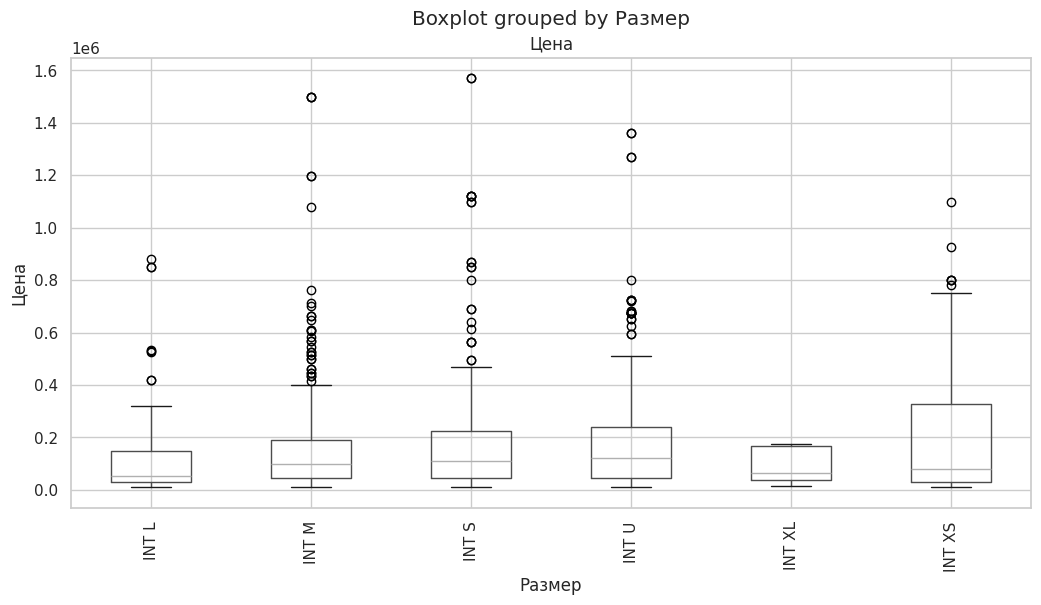

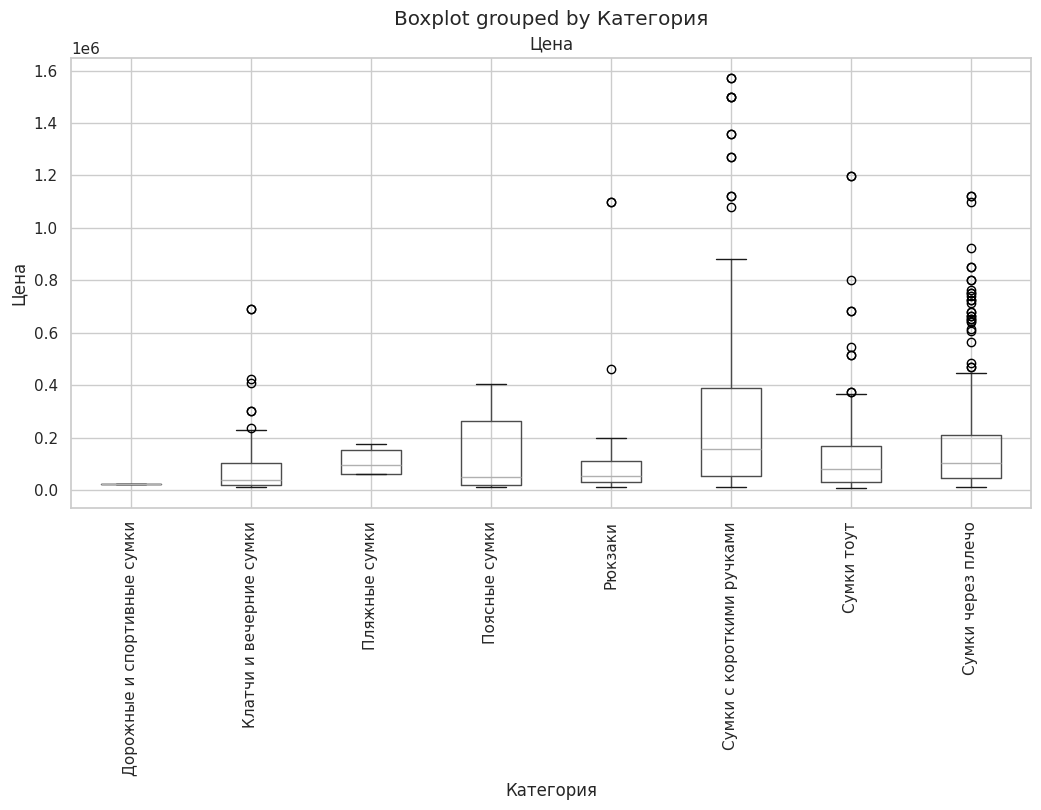

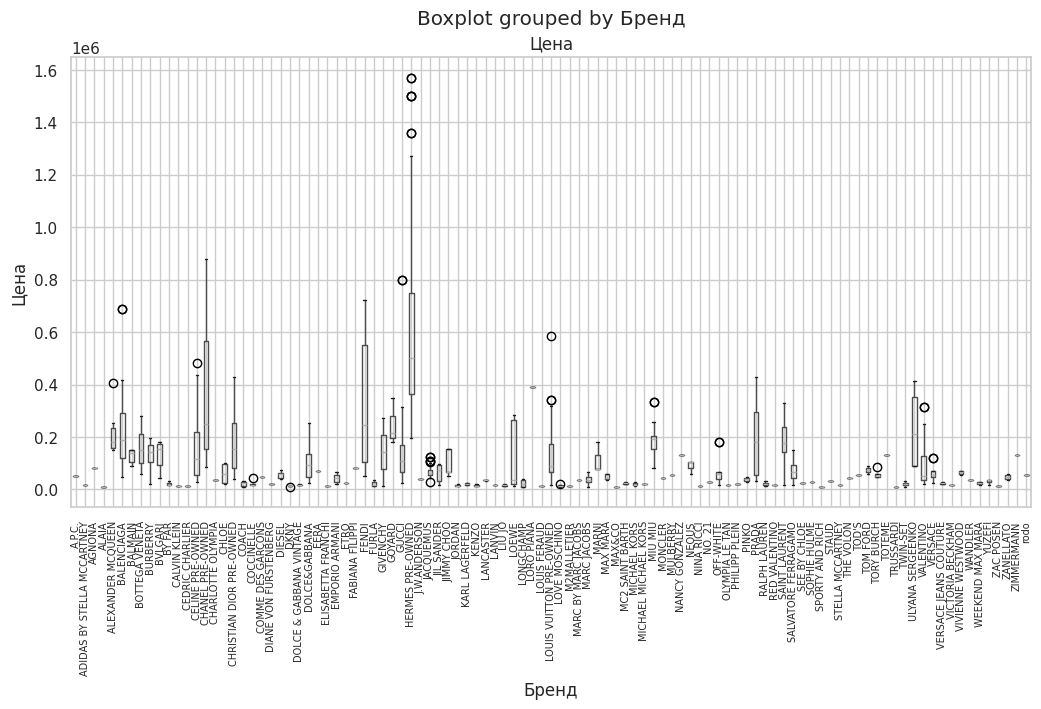

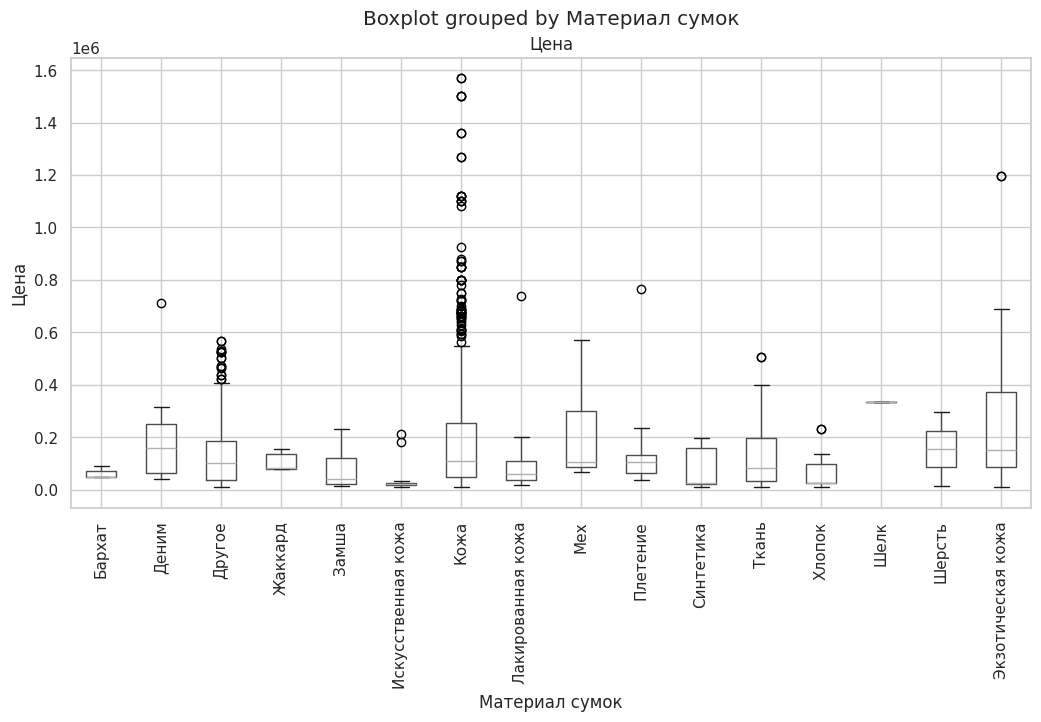

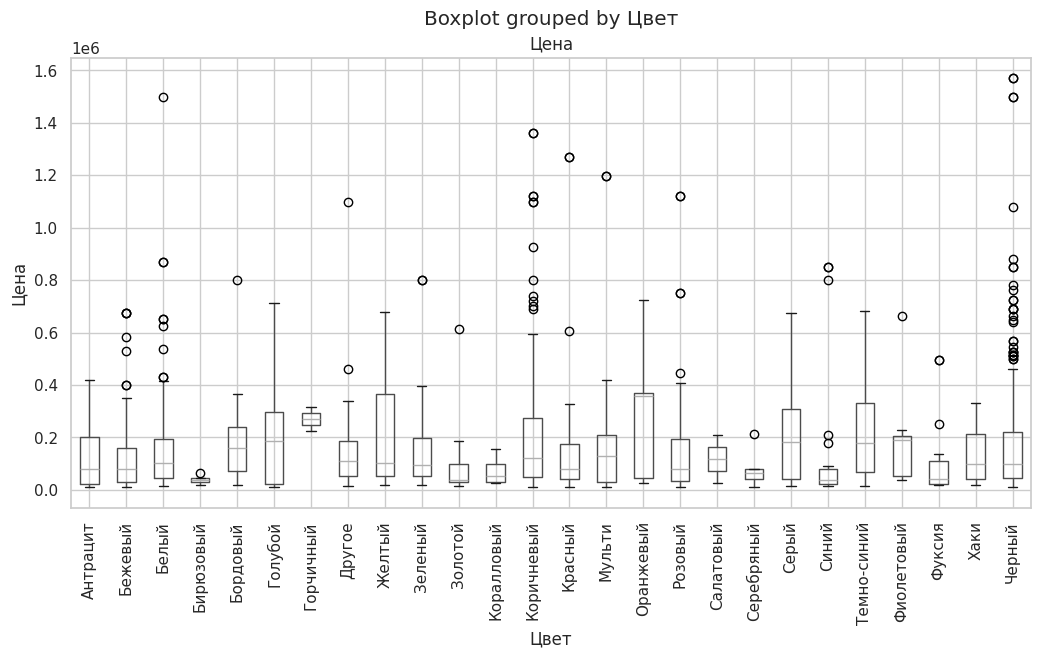

In [101]:
for feat in ['Размер', 'Категория', 'Бренд', 'Материал сумок', 'Цвет']:
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    if feat == 'Бренд':
        ax.set_xticklabels([label.lower() for label in labels])
        ax.tick_params(axis='x', labelsize=7)
    df.boxplot(column='Цена', by=feat, ax=ax, rot=90)
    plt.xlabel(feat)
    plt.ylabel('Цена')
    plt.show()

Как видим, у многих классов значения средних различаются, из-за чего их объединение статистически ухудшит результаты моделей.

Из того, что теоретически возможно слить можно выделить размеры сумок L и XL - судя по ящикам с усами их параметры схожи. Проверим это с помощью t-теста Уэлча и U-теста Манна-Уитни (использовать будем логарифм цены, так как ее распределение ближе к нормальному и не скошено в одну сторону).

<u>Заранее оговоримся, что проверка всех гипотез в нашем исследовании будет проходить на 5% уровне значимости.</u>

In [105]:
mask_L = df['Размер'] == 'INT L'
mask_XL = df['Размер'] == 'INT XL'

price_L = df.loc[mask_L,  'Лог цена']
price_XL = df.loc[mask_XL, 'Лог цена']

# проверка равенства дисперсий - Levene
lev_stat, lev_p = stats.levene(price_L, price_XL, center='median')
print(f'Levene: p‑value = {lev_p:.4f}')

# t-тест Уэлча
t_stat, p_t = stats.ttest_ind(price_L, price_XL, equal_var=False)
print(f'Welch t‑test: t = {t_stat:.3f},  p-value = {p_t:.4f}')

# U-тест Манна-Уитни
u_stat, p_u = stats.mannwhitneyu(price_L, price_XL, alternative='two-sided')
print(f'Mann‑Whitney U‑test: U = {u_stat:.0f},  p-value = {p_u:.4f}')

print()
alpha = 0.05
if p_t > alpha and p_u > alpha:
    print('Нет статистически значимой разницы средних лог‑цен (p > 0.05). Размеры L и XL можно считать однородными по цене.')
else:
    print('Разница средних лог‑цен значима (p <= 0.05). Объединять L и XL некорректно.')

Levene: p‑value = 0.5926
Welch t‑test: t = 0.184,  p-value = 0.8570
Mann‑Whitney U‑test: U = 209,  p-value = 0.8914

Нет статистически значимой разницы средних лог‑цен (p > 0.05). Размеры L и XL можно считать однородными по цене.


In [123]:
# объединяем сумки размера L и XL в одну категорию L+
df_modified_unity = df_modified.copy() # датасет с объединенными категориями, если далее также будем объединять классы, то все изменения в нем
df_modified_unity['Размер'] = df_modified_unity['Размер'].replace({'INT L': 'L+', 'INT XL': 'L+'})

Для использования категориальных характеристик в дальнейших моделях, преобразуем их с помощью One Hot Encoder. 

In [ ]:
df_modified_ohe = pd.get_dummies(df_modified, columns=cat_feats_modified, drop_first=True) #
df_modified_ohe = df_modified_ohe.replace({False: 0, True: 1})
df_modified_ohe.head()

,Наличие пыльника,Винтаж,Наличие коробки,Наличие сертификата,Легенда,Цена,Размер_INT M,Размер_INT S,Размер_INT U,Размер_INT XL,...,Длина ручки_Короткие ручки,Длина ручки_Средние ручки,Состояние товара_Отличное состояние,Состояние товара_Хорошее состояние,Ценовая категория_Доступные,Ценовая категория_Доступный люкс,Ценовая категория_Люксовые,Ценовая категория_Экстремально люксовые,Метод производства_Произведенные на фабрике,Метод производства_Сделанные вручную
0,1,0,0,0,0,52000,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,0,0,0,0,0,38000,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
2,0,0,0,0,1,345000,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,1,0,0,0,27000,0,0,1,0,...,0,1,1,0,0,0,1,0,1,0
4,0,0,0,0,0,17950,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0


### 3. Построить эконометрические модели для цены товара. Подобрать функциональную форму, набор объясняющих переменных, проверить предпосылки теоремы Гаусса-Маркова и гипотезы о нормальности случайной ошибки. Проверить гипотезы о значимости коэффициентов и модели в целом. Выбрать наилучшую модель. Все выводы должны быть тщательно обоснованы количественно.

Начнем с построения модели базовой линейной регрессии.

#### 3.1 Линейная регрессия

In [125]:
# Отделяем X и y
X = df_modified_ohe.drop('Цена', axis=1)
y = df_modified_ohe['Цена']
# Удаляем нечисловые столбцы (если остались)
X = X.select_dtypes(include=['number'])

# Добавляем константу (intercept)
X = sm.add_constant(X)

# Запускаем регрессию
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     7.096
Date:                Wed, 07 May 2025   Prob (F-statistic):           5.07e-85
Time:                        21:32:46   Log-Likelihood:                -14507.
No. Observations:                1051   AIC:                         2.934e+04
Df Residuals:                     887   BIC:                         3.015e+04
Df Model:                         163                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

Посмотрим на список параметров, при которых коэффициенты статистически значимы.

In [126]:
significant_coeffs = model.pvalues[model.pvalues <= 0.05].index.tolist() 
significant_coeffs

['Винтаж',
 'Наличие сертификата',
 'Легенда',
 'Бренд_CHANEL PRE-OWNED',
 'Бренд_CHRISTIAN DIOR PRE-OWNED',
 'Бренд_HERMES PRE-OWNED',
 'Материал сумок_Экзотическая кожа',
 'Длина ручки_Короткие ручки',
 'Ценовая категория_Экстремально люксовые']

**!!!Интерпретация**

Проверяем полученную модель на мультиколлинеарность.

In [162]:
vif_data = pd.DataFrame()
X = df_modified_ohe.drop('Цена', axis=1)
X = X.select_dtypes(include=['number'])
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data['VIF'].value_counts()

VIF
inf            77
1.512685        1
2.220277        1
1.863495        1
2.013690        1
               ..
2.067800        1
1.832658        1
2.438527        1
2.181433        1
2358.884624     1
Name: count, Length: 93, dtype: int64

Как видим, мультиколлинеарность присутствует (есть показатели $VIF > 10$). Попробуем воспользоваться МГК и в случае успеха попутно также решим проблему большого количества параметров.

Изначально берем все главные компоненты и оцениваем на них линейную регрессию.

In [ ]:
X = df_modified_ohe.drop('Цена', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X_scaled)

In [135]:
X_pca = sm.add_constant(X_pca)
model_pca = sm.OLS(y, X_pca).fit()
print(model_pca.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     7.096
Date:                Wed, 07 May 2025   Prob (F-statistic):           5.07e-85
Time:                        22:50:59   Log-Likelihood:                -14507.
No. Observations:                1051   AIC:                         2.934e+04
Df Residuals:                     887   BIC:                         3.015e+04
Df Model:                         163                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.025e+05   8022.326     25.241      0.0

Незначимые главные компоненты удаляем, остальные оставляем.

In [147]:
pvals = model_pca.pvalues
mask  = pvals < 0.05
X_pca_sig = X_pca[:, mask]

print(f'Всего начимых главных компонент (p < 0.05): {mask.sum() - 1}')

Всего начимых главных компонент (p < 0.05): 45


In [148]:
model_pca_sig = sm.OLS(y, X_pca_sig).fit()

print(model_pca_sig.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     24.38
Date:                Wed, 07 May 2025   Prob (F-statistic):          6.28e-130
Time:                        23:04:58   Log-Likelihood:                -14558.
No. Observations:                1051   AIC:                         2.921e+04
Df Residuals:                    1005   BIC:                         2.944e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.025e+05   7909.837     25.600      0.0

In [154]:
X_pca_sig = pd.DataFrame(X_pca_sig).iloc[:, 1:]
X_pca_sig.columns = [f'x{i+1}' for i in range(X_pca_sig.shape[1])]
X_pca_sig.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45
0,0.143869,0.228273,-0.113545,0.989061,-0.591747,-0.469870,-0.960131,-0.420293,-0.994741,2.550865,...,-2.615902,0.667324,-3.193199,-0.951792,1.759204,1.792488,1.559672,0.537365,1.892688,-1.436455
1,-0.840454,-1.228239,1.131071,0.464488,-0.330961,0.384093,0.393676,-0.533409,0.714888,0.964251,...,0.118126,0.494469,0.868357,-0.174299,-0.694947,0.335017,-0.417173,0.709507,-0.430298,-0.953532
2,-0.066362,0.506446,1.662509,-1.124952,1.159622,0.119395,-0.336486,-0.413810,0.664466,-0.815555,...,0.151877,-0.585629,1.301913,-1.223848,-0.050921,-0.444387,0.085264,1.245541,0.815598,0.685501
3,-0.678892,2.859395,-0.403484,-1.322950,-1.068532,1.139328,-0.893101,-0.824594,-1.324513,-0.043965,...,1.100274,0.829227,1.260112,-0.572296,-0.933337,0.808527,0.396542,1.092066,0.374482,-1.295128
4,-2.398157,-1.190994,-3.826036,0.514822,-0.386870,2.326478,-1.741087,-0.974872,-0.120724,-0.152589,...,-1.460419,-1.823537,1.197448,1.157738,0.438649,-0.760648,-1.450232,0.802426,-0.879104,-0.131775


In [161]:
vif_data_pca = pd.DataFrame()
vif_data_pca['feature'] = X_pca_sig.columns
vif_data_pca['VIF'] = [variance_inflation_factor(X_pca_sig.values, i) for i in range(len(X_pca_sig.columns))]
vif_data_pca['VIF'].value_counts()

VIF
1.0    25
1.0    10
1.0     9
1.0     1
Name: count, dtype: int64

Как видим, все параметры в новом параметрическом пространстве имеют $VIF < 10$, то есть мультиколлинеарность в такой выборке отсутствует. При этом $Adj. R^2$, $AIC$ и $BIC$ у модели со значимыми главными компонентами лучше чем у первоночальной модели линейной регрессии ($0.501 > 0.486$, $2921 < 2934$, $2944 < 3015$ соответственно). К сожалению, при использовании подобного рода данных интерпретировать результаты модели не представляется возможным, поэтому давайте попробуем рассмотреть модель линейной регрессии только со значимыми характеристиками.

In [168]:
# линрег только с параметрами со значимыми коэффициентами
X_sc = df_modified_ohe[significant_coeffs]
X_sc = sm.add_constant(X_sc)

model_sc = sm.OLS(y, X_sc).fit()
print(model_sc.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     103.1
Date:                Wed, 07 May 2025   Prob (F-statistic):          1.67e-137
Time:                        23:50:14   Log-Likelihood:                -14610.
No. Observations:                1051   AIC:                         2.924e+04
Df Residuals:                    1041   BIC:                         2.929e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

Как видим, и здесь некоторые коэффициенты оказались незначимы. Отберем отдельно те, что оказались вновь статистически значимы и на них построим новую линейную регрессию.

In [169]:
significant_coeffs_sc = model_sc.pvalues[model_sc.pvalues <= 0.05].index.tolist() 
significant_coeffs_sc

['const',
 'Винтаж',
 'Наличие сертификата',
 'Легенда',
 'Бренд_CHANEL PRE-OWNED',
 'Материал сумок_Экзотическая кожа',
 'Ценовая категория_Экстремально люксовые']

In [166]:
# линрег только с параметрами со значимыми коэффициентами
X_sc_sc = df_modified_ohe[significant_coeffs_sc[1:]]
X_sc_sc = sm.add_constant(X_sc_sc)

model_sc_sc = sm.OLS(y, X_sc_sc).fit()
print(model_sc_sc.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     152.8
Date:                Wed, 07 May 2025   Prob (F-statistic):          3.70e-139
Time:                        23:45:08   Log-Likelihood:                -14614.
No. Observations:                1051   AIC:                         2.924e+04
Df Residuals:                    1044   BIC:                         2.928e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

Как видим, здесь уже все коэффициенты значимы. При этом $Adj. R^2$ все же хуже чем у самой полной модели, но $AIC$ и $BIC$ меньше. Теперь проверим получившуюся модель на мультиколлинеарность.

In [170]:
vif_data_pca = pd.DataFrame()
vif_data_pca['feature'] = X_sc_sc.columns
vif_data_pca['VIF'] = [variance_inflation_factor(X_sc_sc.values, i) for i in range(len(X_sc_sc.columns))]
vif_data_pca['VIF'].value_counts()

VIF
1.436046    1
1.012396    1
1.009598    1
1.132424    1
1.036150    1
1.013753    1
1.127847    1
Name: count, dtype: int64

Как видим, мультиколлинеарность в данной модели отсутствует. Следующим шагом проверим гетероскедастичность. Первым делом посмотрим на график остатки-прогнозы.

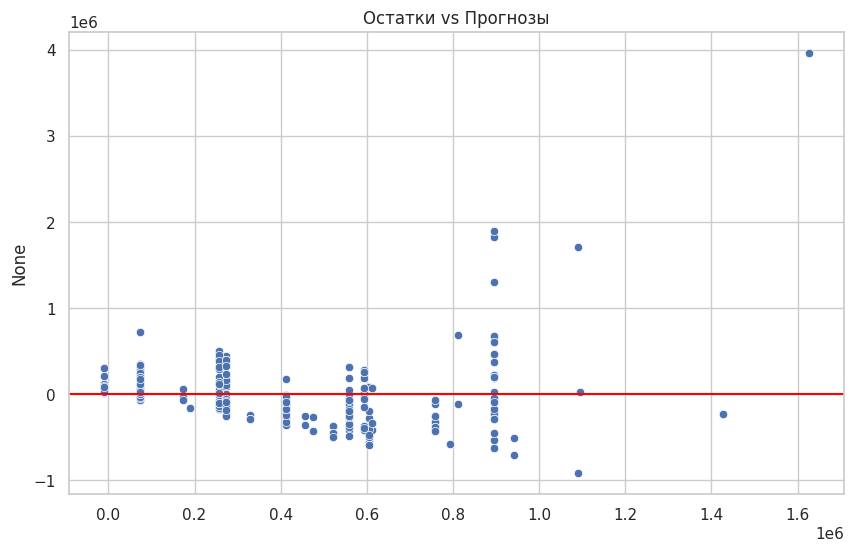

In [171]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=model_sc_sc.predict(), y=model_sc_sc.resid)
plt.axhline(0, color='red')
plt.title('Остатки vs Прогнозы')
plt.show()

Кажется, на графике не наблюдается зависимость разброса остатков от прогнозных значений и средний уровень остатков во всех частях графика не равен нулю, то есть вероятнее в модели не наблюдается гетероскедастичность. При этом похоже, средний уровень остатков зависит от прогнозных значений, что говорит о возможно неверно выбранной функциональной форме. Проверим наши догадки с помощью теста Уайта (Бройша-Пагана).

In [177]:
white_test = het_white(model_sc_sc.resid, model_sc_sc.model.exog)
print(f'White test: p-value: {white_test[1]}')
if white_test[1] > 0.05:
  print('Гомоскедатсичность модели не отвергается')
else:
  print('Гомоскедастичность модели отвергается')

White test: p-value: 7.345950734159816e-198
Гомоскедастичность модели отвергается


In [ ]:
# возможно не совсем подходит, тк в лекции написано:
# Тест Бройша - Пагана применяется в тех случаях, когда
# априорно предполагается, что дисперсии остатков
# зависят от некоторых дополнительных переменных

bp_test = het_breuschpagan(model_sc_sc.resid, model_sc_sc.model.exog)
print(f'P-value теста Бройша-Пагана: {bp_test[1]}')
if bp_test[1]>0.05:
  print('Гомоскедатсичность модели не отвергается')
else:
  print('Гомоскедастичность модели отвергается')

P-value теста Бройша-Пагана: 2.719457670529733e-35
Гомоскедастичность модели отвергается


То есть все же гетероскедастичность в нашей модели присутствует. Для её устранения воспользуемся попрравкой с использованием оценок в форме Davidson и MacKinnon (HC3) для дисперсии коэффициентов. Используется именно эта форма, так как в нашей выборке пристутствуют выбросы по стоимости, которые мы видели при первичном анализе датасета.

In [181]:
model_sc_sc_robust = sm.OLS(y, X_sc_sc).fit(cov_type='HC1')
print(model_sc_sc_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     36.23
Date:                Thu, 08 May 2025   Prob (F-statistic):           5.52e-40
Time:                        01:58:47   Log-Likelihood:                -14614.
No. Observations:                1051   AIC:                         2.924e+04
Df Residuals:                    1044   BIC:                         2.928e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [180]:
white_test = het_white(model_sc_sc_robust.resid, model_sc_sc_robust.model.exog)
print(f'White test: p-value: {white_test[1]}')
if white_test[1] > 0.05:
  print('Гомоскедатсичность модели не отвергается')
else:
  print('Гомоскедастичность модели отвергается')

White test: p-value: 7.345950734159816e-198
Гомоскедастичность модели отвергается


In [182]:
import scipy.stats as stats
shapiro_test = stats.shapiro(model_log_filt.resid)
print(f"P-value теста Шапиро-Уилка: {shapiro_test[1]}")
if shapiro_test[1]>0.05:
  print('Остатки нормальны')
else:
  print('Остатки не нормальны')

NameError: name 'model_log_filt' is not defined